In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


In [3]:
import torch
import jax
import jax.numpy as jnp
import flax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from meta_expl.explainers import load_explainer, create_explainer
from meta_expl.models import load_model, create_model
from meta_expl.data.cifar100 import dataloader, load_data

### define args

In [4]:
# arguments
arch = 'vit-base'
setup = 'static_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
seed = 9
batch_size = 16
max_len = 32*32
num_classes = 100
task_type = "classification"

teacher_dir = 'data/cifar100-vit-models/teacher_dir'
teacher_expl_dir = 'data/cifar100-vit-models/teacher_expl_dir'
student_dir = 'data/cifar100-vit-models/student_dir'
student_expl_dir = 'data/cifar100-vit-models/student_expl_dir'

In [26]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [5]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}
dummy_inputs['input_ids'].shape

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


(16, 1024)

### load data

In [6]:
train_data = load_data(setup, "train")
valid_data = load_data(setup, "valid")
test_data = load_data(setup, "test")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### load models and explainers

In [ ]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(teacher_expl_dir, dummy_inputs, state=dummy_state)
student, student_params, dummy_state = load_model(student_dir, batch_size, max_len)
student_explainer, student_explainer_params = load_explainer(student_expl_dir, dummy_inputs, state=dummy_state)

In [10]:
%env XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false

env: XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false


In [11]:
from meta_expl.utils import PRNGSequence
keyseq = PRNGSequence(seed)

teacher_explainer_params={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': None,
    'head_idx': None
}

teacher, teacher_params, dummy_state = create_model(
    key=next(keyseq),
    inputs=dummy_inputs,
    vocab_size=1,
    num_classes=num_classes,
    arch=arch,
    batch_size=batch_size,
    max_len=max_len,
    embeddings=None,
)
teacher_explainer, teacher_explainer_params = create_explainer(
    key=next(keyseq),
    inputs=dummy_inputs,
    state=dummy_state,
    explainer_type='attention_explainer',
    explainer_args=teacher_explainer_params,
)

2022-03-05 14:07:48.759488: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-03-05 14:07:48.768581: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-03-05 14:07:48.768609: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-03-05 14:07:48.771224: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-03-05 14:07:48.773960: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CU

RuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv = (f32[1,14,14,768]{2,1,3,0}, u8[0]{0}) custom-call(f32[1,224,224,3]{2,1,3,0} %copy.3, f32[16,16,3,768]{1,0,2,3} %copy.4), window={size=16x16 stride=16x16}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated[window_strides=(16, 16) padding=((0, 0), (0, 0)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 lhs_shape=(1, 224, 224, 3) rhs_shape=(16, 16, 3, 768) precision=None preferred_element_type=None]" source_file="/home/mtreviso/meta-expl/env/lib/python3.8/site-packages/flax/linen/linear.py" source_line=270}, backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"

Original error: UNIMPLEMENTED: DNN library is not found.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

### look at the coefficients

In [ ]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)

In [ ]:
hc = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)
for a, b in zip(*hc.nonzero()):
    print(a, b, hc[a,b])

## plot explanations

In [22]:
from captum.attr import visualization

2022-03-05 19:30:40.442773: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:618] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2022-03-05 19:30:40.443457: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:618] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Gold: 60
Pred: 60


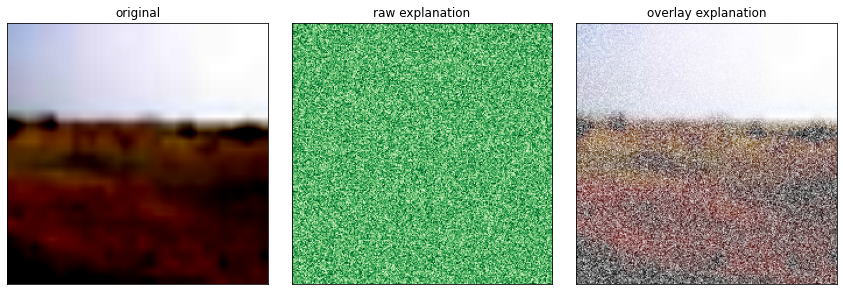

In [88]:
def show_explanation(idx, data):
    x, y = next(dataloader([data[idx]], tokenizer=feature_extractor, batch_size=1, max_len=None, shuffle=False))
    x = np.asarray(x['pixel_values'].squeeze(0).transpose(1, 2, 0))  # h, w, c
    y = np.asarray(y.squeeze(0))
    # expl = np.asarray(flax.nn.softmax(np.random.rand(*x.shape), axis=-2))
    expl = np.random.rand(*x.shape)

    print('Gold:', y)
    print('Pred:', y)
    visualization.visualize_image_attr_multiple(expl, x, 
                                                methods=['original_image', 'heat_map', 'alpha_scaling'],
                                                signs=['positive', 'positive', 'positive'],
                                                titles=['original', 'raw explanation', 'overlay explanation'],
                                                fig_size=(12, 4))
    
show_explanation(idx=0, data=test_data)